<a href="https://colab.research.google.com/github/mrnobody075/Workforce-Efficiency-System-Using-Computer-Vision-and-Django/blob/main/objectdetectionandtracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Major project for object detection and tracking of the people entering through the entrance**

In [ ]:
!pip install ultralytics deep_sort_realtime opencv-python-headless

  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl (664.8 MB)


100%|██████████| 49.7M/49.7M [00:00<00:00, 247MB/s]



0: 384x640 2 persons, 5 potted plants, 41.0ms
Speed: 2.0ms preprocess, 41.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


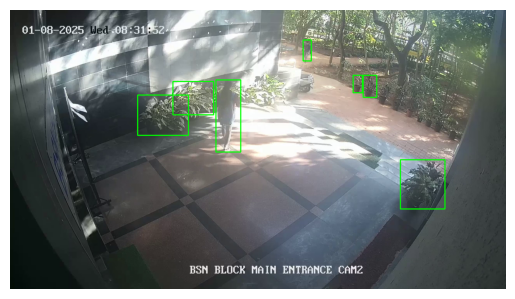

In [ ]:
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt

# Change to your video filename
VIDEO_PATH = '/content/bsnentrancerawfile.mp4'  # Or '/content/drive/MyDrive/entrance.mp4'

model = YOLO('yolov8m.pt')

cap = cv2.VideoCapture(VIDEO_PATH)

ret, frame = cap.read()
if ret:
    results = model(frame)
    for box in results[0].boxes.xyxy:
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
    # Show result in notebook
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
else:
    print("Failed to load video")

cap.release()


0: 384x640 2 persons, 5 potted plants, 26.9ms
Speed: 2.1ms preprocess, 26.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


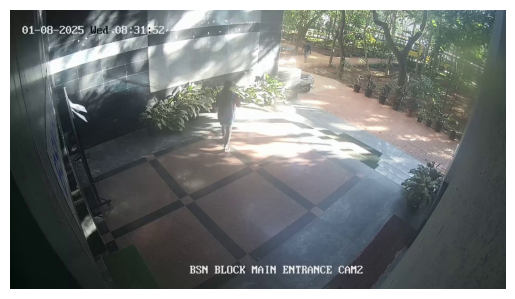

In [ ]:
import cv2
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort
import matplotlib.pyplot as plt

# Load YOLOv8m model (since it works best for you)
model = YOLO('yolov8m.pt')

# Initialize DeepSORT tracker
tracker = DeepSort(max_age=30)

# Change this to your video path
VIDEO_PATH = '/content/bsnentrancerawfile.mp4'

cap = cv2.VideoCapture(VIDEO_PATH)
ret, frame = cap.read()

# Just process first frame for demo, remove this loop to process whole video
if ret:
    results = model(frame)
    detections = []
    for box, conf, class_id in zip(results[0].boxes.xyxy, results[0].boxes.conf, results[0].boxes.cls):
        if int(class_id) == 0:  # Only 'person' class
            x1, y1, x2, y2 = map(int, box)
            detections.append(([x1, y1, x2 - x1, y2 - y1], float(conf), 'person'))

    tracks = tracker.update_tracks(detections, frame=frame)
    for track in tracks:
        if not track.is_confirmed():
            continue
        track_id = track.track_id
        l, t, r, b = map(int, track.to_ltrb())
        cv2.rectangle(frame, (l, t), (r, b), (255, 0, 0), 2)
        cv2.putText(frame, f'ID:{track_id}', (l, t - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,0,0), 2)

    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
else:
    print("Failed to load video.")
cap.release()

**Final code**

In [ ]:
#Final Code
import cv2
import random
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort

# Load YOLOv8 model
model = YOLO('yolov8m.pt')

# Initialize DeepSORT tracker
# max_age = 15, maximum number of frames an object can remain undetected before it's deleted from the tracker.
# init= 3, This is the number of consecutive detections required to confirm a new track.
# max_cosine_distance=0.3,  This is a threshold for matching appearance features between detections and existing tracks.
# Initialize DeepSORT tracker
tracker = DeepSort(max_age=15, n_init=3, max_cosine_distance=0.3)

VIDEO_PATH = '/content/bsnentrancerawfile.mp4'
OUTPUT_PATH = '/content/output_tracked.mp4'

cap = cv2.VideoCapture(VIDEO_PATH)
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(OUTPUT_PATH, fourcc, fps, (width, height))
entry_line_x = 250 # Vertical line 250px from the left edge
count_in = 0
count_out = 0
track_positions = {}

# Inside the frame processing loop:

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    results = model(frame, conf=0.4)[0]

    detections = []
    for box in results.boxes:
        cls_id = int(box.cls[0])
        conf = float(box.conf[0])
        if cls_id == 0:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            detections.append(([x1, y1, x2 - x1, y2 - y1], conf, 'person'))

    tracks = tracker.update_tracks(detections, frame=frame)

    for track in tracks:
        if not track.is_confirmed():
            continue

        track_id = track.track_id
        x1, y1, x2, y2 = map(int, track.to_ltrb())
        cx = (x1 + x2) // 2
        cy = (y1 + y2) // 2

        prev_x = track_positions.get(track_id)
        track_positions[track_id] = cx

        if prev_x is not None:
            if prev_x > entry_line_x and cx <= entry_line_x:
                count_in += 1
            elif prev_x < entry_line_x and cx >= entry_line_x:
                count_out += 1

        # Draw bounding box with unique color
        color = get_color(track_id)
        cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
        cv2.putText(frame, f'ID: {track_id}', (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    # Draw vertical entry line
    cv2.line(frame, (entry_line_x, 0), (entry_line_x, height), (0, 0, 255), 2)

    # Show counts in top-left corner
    cv2.putText(frame, f'IN: {count_in}', (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 200, 0), 3)
    cv2.putText(frame, f'OUT: {count_out}', (10, 70),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)

    out.write(frame)

cap.release()
out.release()
cv2.destroyAllWindows()

Streaming output truncated to the last 5000 lines.
0: 544x960 3 persons, 3 potted plants, 67.7ms
Speed: 7.4ms preprocess, 67.7ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 960)

0: 544x960 3 persons, 1 handbag, 3 potted plants, 68.3ms
Speed: 7.6ms preprocess, 68.3ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 960)

0: 544x960 3 persons, 1 handbag, 3 potted plants, 66.5ms
Speed: 6.1ms preprocess, 66.5ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 960)

0: 544x960 3 persons, 5 potted plants, 68.3ms
Speed: 8.7ms preprocess, 68.3ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 960)

0: 544x960 3 persons, 4 potted plants, 69.4ms
Speed: 6.8ms preprocess, 69.4ms inference, 2.2ms postprocess per image at shape (1, 3, 544, 960)

0: 544x960 3 persons, 5 potted plants, 68.0ms
Speed: 9.5ms preprocess, 68.0ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 960)

0: 544x960 3 persons, 5 potted plants, 68.0ms
Speed: 9.5ms prep

Found 3 files.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


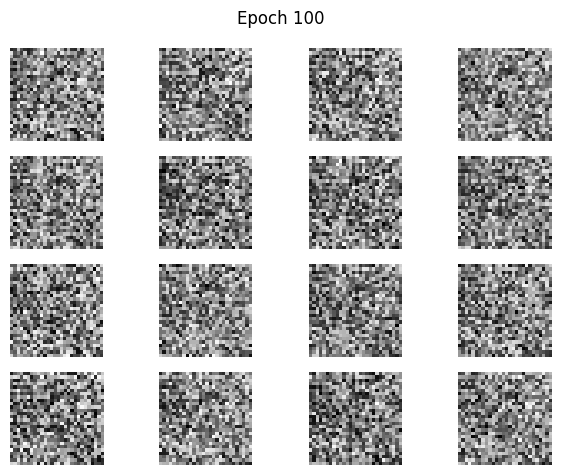

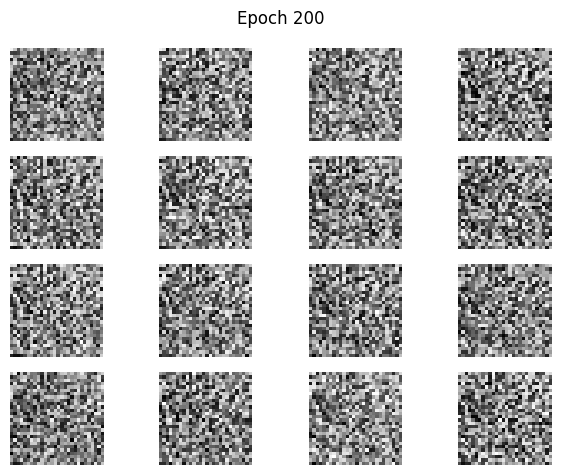

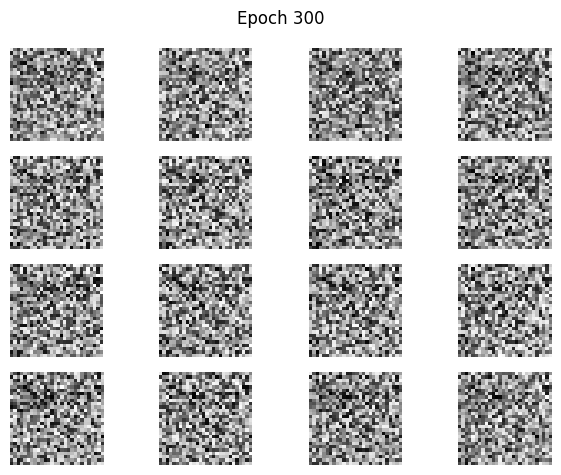

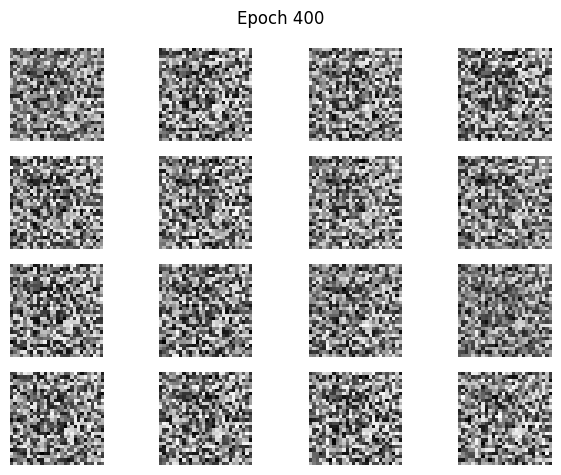

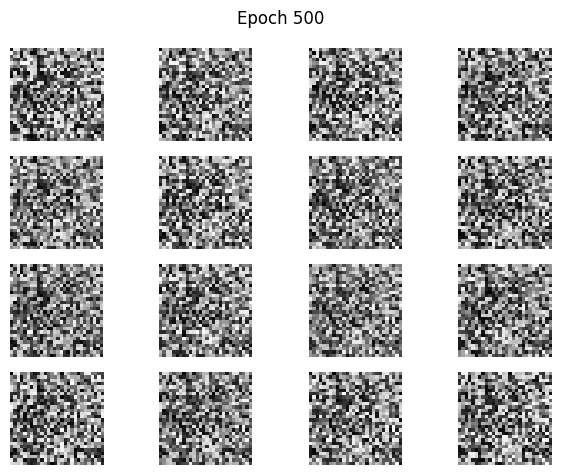

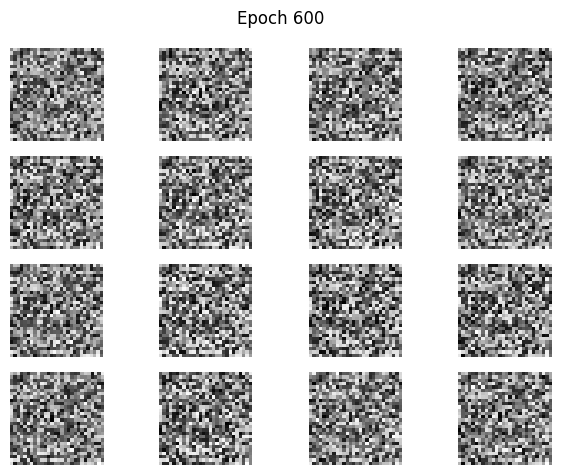

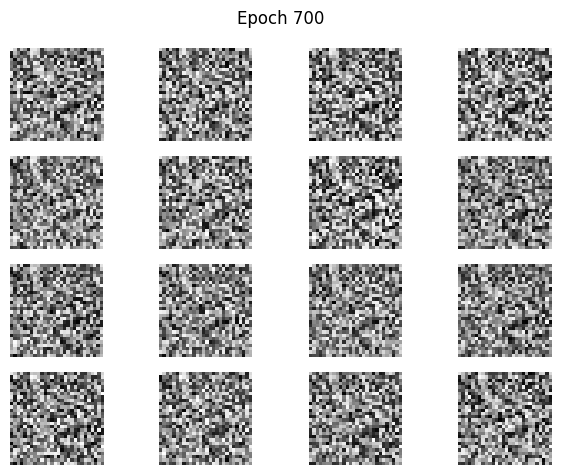

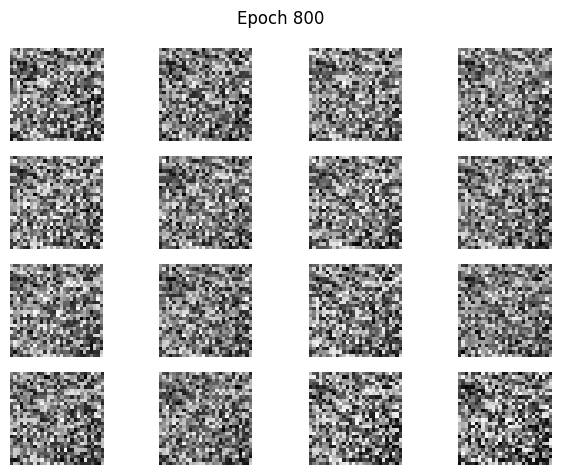

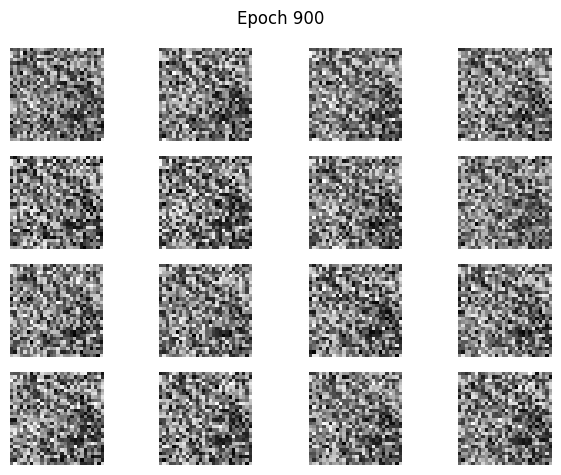

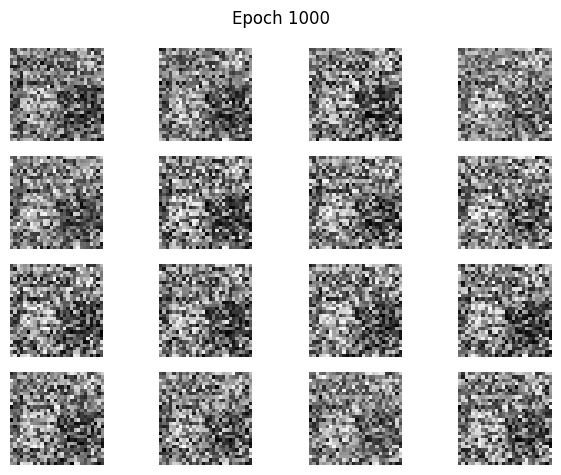

In [ ]:
import tensorflow as tf, matplotlib.pyplot as plt

# Params
path = '/content/catimg'
H, W, B, Z = 28, 28, 128, 100

# Data
ds = tf.keras.preprocessing.image_dataset_from_directory(
    path, label_mode=None, image_size=(H, W), color_mode='grayscale', batch_size=B
).map(lambda x: (x/127.5)-1)

# Models
gen = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(Z,)),
    tf.keras.layers.Dense(H*W, activation='tanh'),
    tf.keras.layers.Reshape((H, W, 1))
])
disc = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(H, W, 1)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Train step
bce, gopt, dopt = tf.keras.losses.BinaryCrossentropy(from_logits=True), tf.keras.optimizers.Adam(1e-4), tf.keras.optimizers.Adam(1e-4)
@tf.function
def train(real):
    noise = tf.random.normal([B, Z])
    with tf.GradientTape() as g, tf.GradientTape() as d:
        fake = gen(noise)
        r, f = disc(real), disc(fake)
        dl = bce(tf.ones_like(r), r) + bce(tf.zeros_like(f), f)
        gl = bce(tf.ones_like(f), f)
    dopt.apply_gradients(zip(d.gradient(dl, disc.trainable_variables), disc.trainable_variables))
    gopt.apply_gradients(zip(g.gradient(gl, gen.trainable_variables), gen.trainable_variables))

# Loop
for e in range(1, 1001):
    for x in ds: train(x)
    if e % 100 == 0:
        imgs = (gen(tf.random.normal([16, Z]), training=False) + 1) / 2
        for i in range(16):
            plt.subplot(4, 4, i+1)
            plt.imshow(imgs[i, :, :, 0], cmap='gray')
            plt.axis('off')
        plt.suptitle(f"Epoch {e}"); plt.tight_layout(); plt.show()
